In [ ]:

! pip install langchain_community
! pip install langchain_text_splitters
! pip install langchain-core
! pip install "unstructured[md]" nltk
! pip install -qU langchain-text-splitters
! pip install faiss-cpu
! pip install langchain_ollama
! pip install tiktoken

In [ ]:
# Setup Ollama
!sudo apt update
!sudo apt install -y pciutils
!curl -fsSL https://ollama.com/install.sh | sh

In [9]:
import threading
import subprocess
import time

def run_ollama_serve():
  subprocess.Popen(["ollama", "serve"])

thread = threading.Thread(target=run_ollama_serve)
thread.start()
time.sleep(5)

In [19]:
!ollama pull nomic-embed-text
!ollama pull llama3.2:3b

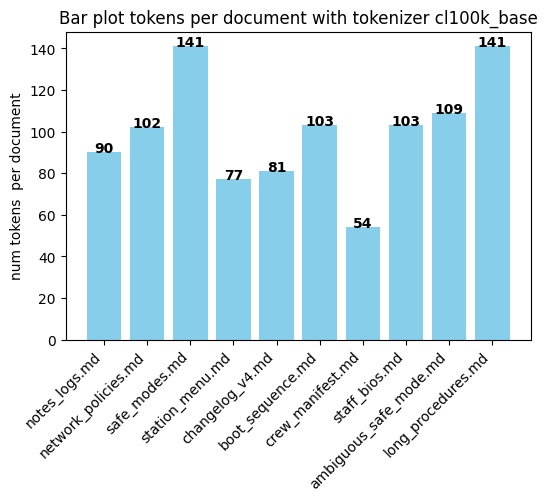

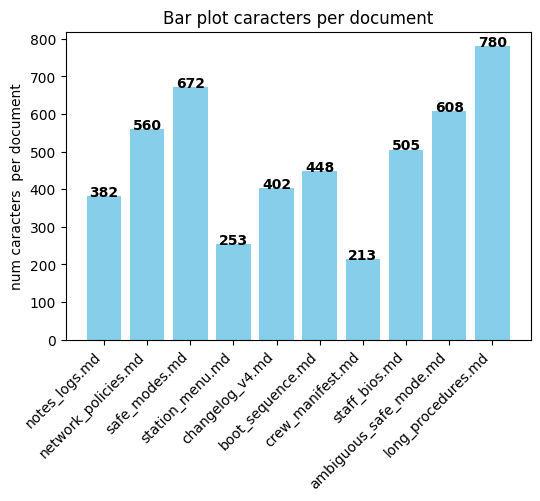

In [6]:
from langchain_community.document_loaders import UnstructuredMarkdownLoader
import os
import matplotlib.pyplot as plt
import tiktoken


def get_metric(md_folder):
  md_files =[file for file in os.listdir(md_folder) if file.endswith('.md')]

  num_tokens = []
  num_caracters=[]
  tokenizer = tiktoken.get_encoding(encoding_name="cl100k_base")

  for file in md_files:
    file_path=os.path.join(md_folder, file)
    loader = UnstructuredMarkdownLoader(file_path, encoding="utf-8")
    document = loader.load()

    for page in document:
      tokens=tokenizer.encode(page.page_content)
      num_caracters.append(len(list(page.page_content)))
      num_tokens.append(len(tokens))

  return num_tokens, num_caracters, md_files

def plot_metric(tokens, caracters, files):

 # Plot tokens per document with cl100k_base
  plt.figure(figsize=(6, 4))
  plt.bar(files, tokens, color='skyblue')
  plt.xticks(rotation=45, ha='right', fontsize=10)
  for i, v in enumerate(tokens):
    plt.text(i, v + 0.01, f"{int(v):.0f}", ha='center', fontweight='bold')

  plt.ylabel('num tokens  per document')
  plt.title('Bar plot tokens per document with tokenizer cl100k_base')

  plt.figure(figsize=(6, 4))
  plt.bar(files, caracters, color='skyblue')
  plt.xticks(rotation=45, ha='right', fontsize=10)
  for i, v in enumerate(caracters):
    plt.text(i, v + 0.01, f"{int(v):.0f}", ha='center', fontweight='bold')

  plt.ylabel('num caracters  per document')
  plt.title('Bar plot caracters per document')
  plt.show()


if __name__=='__main__':
  md_folder = '/content/sample_data/data'
  num_tokens, num_caracters, md_files = get_metric(md_folder)
  plot_metric(num_tokens, num_caracters, md_files)



In [ ]:
!ollama pull mxbai-embed-large

In [20]:
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_text_splitters import CharacterTextSplitter
from langchain_ollama import OllamaEmbeddings
from langchain_core.documents import Document
import os
import argparse

class DocProcessing():
  def __init__(self,
               path_to_docs:str,                  # path to the folder containing .md files
               save_folder:str,
               embed_model_name="nomic-embed-text", #"mxbai-embed-large",
               doc_type:str ='.md',
               chunk_size=160,
               chunk_overlap=10,
               max_tokens = 1024,
               splitter_type='token',
               save_vector_store=True,
               ):

    self.path_to_docs = path_to_docs
    self.chunk_size = chunk_size
    self.chunk_overlap = chunk_overlap
    self.k = 2 # max_tokens//chunk_size,
    self.embedding_name = embed_model_name
    self.extension = doc_type
    self.splitter_type =splitter_type
    self.save = save_vector_store
    self.save_folder = save_folder
    self.embeddings = OllamaEmbeddings(model=self.embedding_name)

  def text_splitter(self, docs):
    if self.splitter_type == 'recursive':
      text_splitter = RecursiveCharacterTextSplitter(chunk_size=self.chunk_size, chunk_overlap=self.chunk_overlap)

    if self.splitter_type == 'token':
      text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
      encoding_name="cl100k_base", chunk_size=self.chunk_size, chunk_overlap=self.chunk_overlap )

    texts = text_splitter.split_text(docs)
    return texts

  def load_and_split_file(self, file_path):
    content = [ ]
    loader = UnstructuredMarkdownLoader(file_path, encoding="utf-8")
    document = loader.load()
    for page in document:
      txts=self.text_splitter(page.page_content)
      Docs =[Document(page_content=t) for t in txts]
      content += Docs
    return content

  def load_and_split_folder(self):
    content=[]
    files = [file for file in os.listdir(self.path_to_docs) if file.endswith(self.extension)]
    for file in files:
      file_path=os.path.join(self.path_to_docs, file)
      content+=self.load_and_split_file(file_path)
    return  content

  def save_vectorstore(self, texts):
    vectorstore = FAISS.from_documents(texts, embedding=self.embeddings)
    if self.save :
      vectorstore.save_local(self.save_folder)
    else :
      return vectorstore

  def load_vectorstore(self):
    vectorstore = FAISS.load_local(self.save_folder, self.embeddings, allow_dangerous_deserialization=True)
    retriever = vectorstore.as_retriever(search_kwargs={"k": self.k})
    return retriever

if __name__ =='__main__':

  path_to_docs = '/content/sample_data/data'
  save_folder = '/content/sample_data/data/faiss_index'
  Processing  = DocProcessing(path_to_docs, save_folder=save_folder)
  texts_chunks = Processing.load_and_split_folder()
  Processing.save_vectorstore(texts_chunks)



In [21]:
retriever = Processing.load_vectorstore()
for page in retriever.invoke('network policies is an important aspect'):
  print(page.page_content , '\n \n ### Next chunk ### \n' )

Network Policies

AI modules must not initiate outbound connections without Commander override.

Internal telemetry uplinks are allowed.

In “Safe Mode” (ambiguous term), external bridges may remain active or be shut down, depending on firmware version.

v3.x firmware mistakenly allows redundant outbound packets causing leaks — fixed by Patch 7-F.

Emergency overrides can bypass all network restrictions, but only by Commander or AI Ethics Officer.

Contradiction: Some docs say Isolation disables outbound traffic; others note telemetry uplinks are exempt. 
 
 ### Next chunk ### 

Safe Modes

ZentroSoft supports multiple safe operation modes that vary by version and context:

SafeBoot: Skips non-critical modules for faster boot

LowPower: Disables high-energy systems like communications and sensors

Isolation: Cuts all external network bridges, sometimes referred to as “Safe Mode” in legacy docs

Passive Mode (deprecated): AI only logs but takes no action

Safe Mode (conflicting): In fir

In [ ]:
# Evaluate the retriever
import json
import matplotlib.pyplot as plt

def evaluate(eval_json, md_folder, retriever, proc:DocProcessing):

  with open(eval_json, 'r') as eval:
    eval = json.load(eval)

  # get relevant chunks and invoke_query
  md_files = [file for file in  os.listdir(md_folder)  if file.endswith('.md')]
  keys = [file[:-3] for file in md_files ]
  relevant_dict = {}
  retrieved_dict = {}

  for i, k  in enumerate(keys) :

    retrieved_dict[k] = [page.page_content for page in retriever.invoke(eval[k])]
    md_path = os.path.join(md_folder, md_files[i])
    relevant_dict[k] = [page.page_content for page in proc.load_and_split_file(md_path)]

  # Calculate the recall and precision
  recalls = []
  precisions = []
  for k in keys:
    rec = 0
    prec= 0
    for chunk  in relevant_dict[k]:
      if  chunk in retrieved_dict[k]:
        rec+=1
    rec /= len(relevant_dict[k])
    for chunk in retrieved_dict[k]:
      if chunk in relevant_dict[k]:
        prec+=1
    prec /= len(retrieved_dict[k])

    recalls.append(rec)
    precisions.append(prec)

  return recalls, precisions, keys

def plot(recs, precs, keys):

 # Plot Recall per document
  plt.figure(figsize=(10, 6))
  plt.bar(keys, recs, color='skyblue')
  plt.xticks(rotation=45, ha='right', fontsize=10)
  for i, v in enumerate(recs):
    plt.text(i, v + 0.01, f"{int(v*100):.0f}%", ha='center', fontweight='bold')

  plt.ylabel('Recall per document')
  plt.ylim(0, 1)

  # Plot Precision per document
  plt.figure(figsize=(10, 6))
  plt.bar(keys, precs, color='skyblue')
  plt.xticks(rotation=45, ha='right', fontsize=10)
  for i, v in enumerate(precs):
    plt.text(i, v + 0.01, f"{int(v*100):.0f}%", ha='center', fontweight='bold')

  plt.ylabel('Precision per document')
  plt.ylim(0, 1)

  plt.show()


if __name__=='__main__' :
  json_file ='/content/sample_data/data/evaluation.json'
  md_fold = '/content/sample_data/data'
  save_folder = '/content/sample_data/data/faiss_index'
  proc= DocProcessing(md_fold, save_folder)
  retr = proc.load_vectorstore()
  recalls, precs, names = evaluate(json_file, md_fold, retr, proc)
  plot(recalls, precs, names)


In [22]:
# prepare the questions
import json
from langchain_ollama.llms import OllamaLLM
import tiktoken

llm  = OllamaLLM(model="llama3.2:3b")

def get_questions(file):
  out  ={}
  with open(file ,'r') as questions:
     q =json.load(questions)
  qs =q['questions']

  for question in qs :
    out[question['id']]=question["question"]
  return out

def verify_tokens_count(doc_string):
  tokenizer = tiktoken.get_encoding(encoding_name="cl100k_base")
  tokens = tokenizer.encode(doc_string)
  num_tokens =len(tokens)

  if num_tokens > 1024:
    raise ValueError(f"Context too long: {num_tokens} tokens (limit is {1024})")

  return num_tokens


def rag_bot(question: str) -> dict:

    docs = retriever.invoke(question)
    docs_string = "".join(doc.page_content for doc in docs)

    instructions = f"""You are a helpful assistant who is good at analyzing source information
    and answering questions. Use the following source documents to answer the user's questions.
    Be as concise as possible in your answers.
    Documents:
    {docs_string}"""

    try :
      verify_tokens_count(docs_string)
      ai_msg = llm.invoke([
              {"role": "system", "content": instructions},
              {"role": "user", "content": question},
          ],
      )
      return {"answer": ai_msg, "documents": [doc.page_content for doc in  docs]}

    except ValueError as e:
      print("Error:", e)


q_file  = '/content/sample_data/data/questions.json'
a_file = '/content/sample_data/data/answers.json'
questions = get_questions(q_file)
answers ={}
for id , q in questions.items():
  answers[id]=rag_bot(q)
  break
with open(a_file , 'w') as ans:
  json.dump(answers , ans ,indent=2)



In [23]:
answers

{'q1': {'answer': 'If the QRC (Quantum Relay Controller) fails during boot, the expected system behavior is:\n\n- SafeBoot will be initiated, but AI command queueing may not work as intended due to Isolation Mode being triggered.\n- The system will attempt to initialize AI diagnostics manually.\n\nRecommended recovery steps include:\n\n1. Disabling AI Layer autoload completely and rebooting with minimal profile.\n2. Inspecting QRC diagnostic output with qrc_diag --trace.\n3. If diagnostics fail, escalating privileges to Commander level to verify override routes.\n4. Manually restoring communications modules if Isolation Mode was triggered.\n5. Re-enabling AI Layer only after successful network sync.\n\nThis process may take approximately 20 minutes under normal conditions and should be followed strictly to minimize downtime.',
  'documents': ['ZentroSoft OS Changelog – Version 4.2\n\nFixed QRC startup hang during SafeBoot.\n\nUpdated Isolation Mode to block AI command queueing.\n\nDepr

In [24]:
questions


{'q1': 'If the QRC fails during boot, what is the expected system behavior and recommended recovery steps?',
 'q2': "Explain the ambiguity around the term 'Safe Mode' and how it might affect operator decisions.",
 'q3': 'What contradictions exist in network policies regarding AI outbound communication?',
 'q4': 'Describe the procedure to manually restore communications modules if Isolation Mode was triggered.',
 'q5': 'Who is authorized to override network restrictions, and what conflicts might arise?'}